In [1]:
# Import our relevant libraries:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import fisher_exact
from scipy.stats import zscore
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
import scanpy as sc
import anndata
import matplotlib
from matplotlib.pyplot import rc_context
import numba
import os
import scrublet as scr
from scipy.stats import ttest_ind
from sklearn import metrics

In [2]:
# Adjust font and visual modifications of the plots for the journal:
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['axes.axisbelow'] = True

In [3]:
# set directory for saving the plots:
sc.settings.figdir = r'C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\CD38_project_code\cd38_project'

In [4]:
# Load the scRNAseq data from the Single-Cell Portal (counts already provided as TPM):
adata = sc.read_text(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\tpm_all_scp.txt.gz")
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 16291 × 12364

In [5]:
# Apply log2 transformation:
sc.pp.log1p(adata, base = 2)

In [6]:
# Load the single-cell tSNE for all the cells:
tsne_all = pd.read_csv(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\storage.googleapis.com_fc-62f6efcb-4e94-473b-8d35-42a4d85d6260_tSNE_all_scp.txt", sep = '\t', header = 1, index_col = 0)

# Load the single-cell tSNE for CD8 T cells:
tsne_cd8 = pd.read_csv(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\storage.googleapis.com_fc-62f6efcb-4e94-473b-8d35-42a4d85d6260_tSNE_CD8_scp.txt", sep = '\t', header = 1, index_col = 0)

In [7]:
# focus specifically on CD8 T cells:
cd8_adata = adata[adata.obs_names.isin(tsne_cd8.index)]
cd8_adata

View of AnnData object with n_obs × n_vars = 6350 × 12364
    uns: 'log1p'

In [8]:
# add tSNE coordinates for CD8 T cells:
cd8_adata.obsm['X_tsne'] = tsne_cd8[['numeric', 'numeric.1']].values

In [9]:
# Load the single-cell metadata for all the cells:
metadata = pd.read_csv(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\storage.googleapis.com_fc-62f6efcb-4e94-473b-8d35-42a4d85d6260_cells_all_scp.txt", sep = '\t', header = 0, index_col = 0).iloc[1:, :]

In [10]:
# Add the single-cell metadata to the anndata object:
for col in metadata.columns:
    cd8_adata.obs[col] = metadata[col]
cd8_adata

AnnData object with n_obs × n_vars = 6350 × 12364
    obs: 'response', 'patient', 'cluster_all', 'isCD8', 'cluster_cd8', 'isDNDP', 'prepost', 'pNum', 'gender', 'age', 'therapy', 'survival_days', 'status', 'biopsyNum', 'plate', 'MNum', 'rMito'
    uns: 'log1p'
    obsm: 'X_tsne'

In [11]:
# map each CD8 cluster to its cluster name according to the authors:
cluster2annotation = {
     '1': 'C1: Exhaustion/cell cycle',
     '2': 'C2: Exhaustion/heat shock protein',
     '3': 'C3: Exhaustion',
     '4': 'C4: Effector/memory',
     '5': 'C5: Early activated',
     '6': 'C6: Effector/memory'
}

# add a new `.obs` column by mapping clusters to annotation using pandas `map` function:
cd8_adata.obs['cluster_cd8'] = cd8_adata.obs['cluster_cd8'].map(cluster2annotation).astype('category')

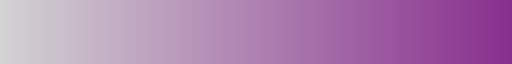

In [12]:
# create a continuous cmap from lightgray to purple color for visualization:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

c1='lightgray' #lightgray color by hex name
c2='#882f8e' #purple color by hex name
n=500

colors = []
for x in range(n+1):
    colors.append(colorFader(c1,c2,x/n))
    
# create the cmap structure from these two colors:
colors = [matplotlib.colors.to_rgba(color) for color in colors]
colors = np.array(colors)
cmap = matplotlib.colors.ListedColormap(colors)

cmap

# Main Figure 1, panels A-E:

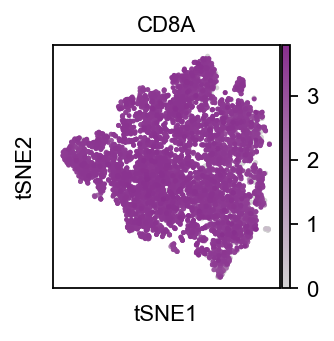

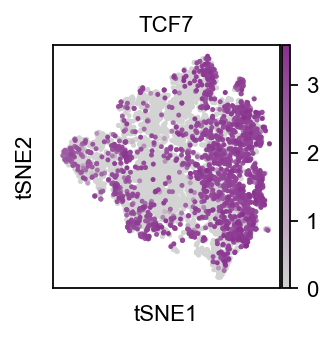

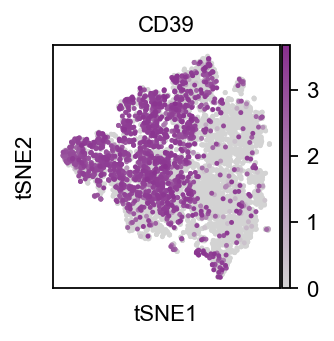

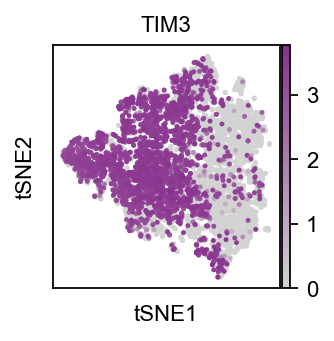

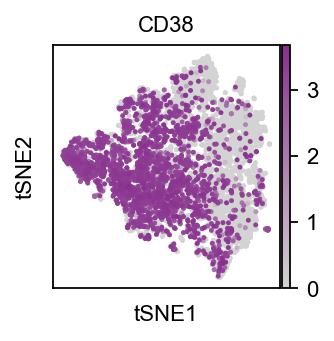

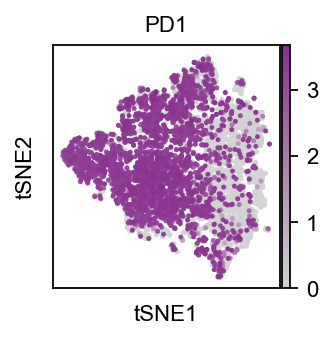

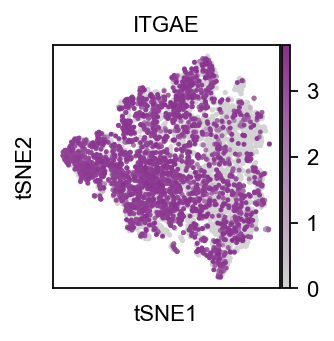

In [13]:
# Create UMAP plots for selected genes:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2, 2), fontsize = 10, facecolor='white', format = 'jpeg')
titles = ['CD8A', 'TCF7', 'CD39', 'TIM3', 'CD38', 'PD1', 'ITGAE']
colors = ['CD8A', 'TCF7', 'ENTPD1', 'HAVCR2', 'CD38', 'PDCD1', 'ITGAE']
for col in range(len(colors)):
    sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4, cmap = cmap)
#     sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4, cmap = cmap, save = f'_{titles[col]}_or_yam_palette')

In [14]:
# Set colors of 'Response'/'No response' based on our palette:
cd8_adata.uns['response_colors'] = ['#882f8e', '#d3d3d3']

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


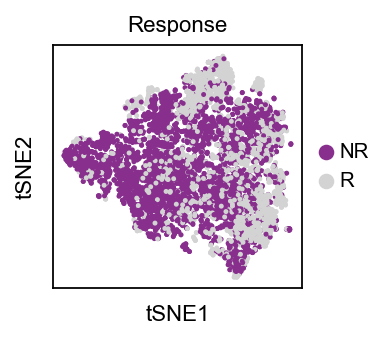

In [15]:
# Create a UMAP plot for response:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2, 2), fontsize = 10, facecolor='white', format = 'jpeg')
titles = ['Response']
colors = ['response']
for col in range(len(colors)):
    sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4)
#     sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4, save = f'_{titles[col]}_or_yam_palette')

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


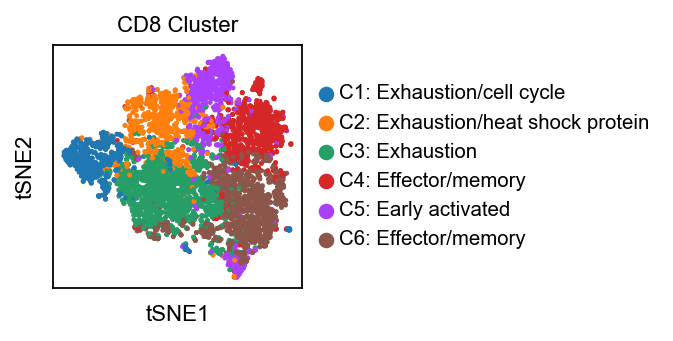

In [16]:
# Create a UMAP plot for CD8 cluster udentity:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2, 2), fontsize = 10, facecolor='white', format = 'tiff')
titles = ['CD8 Cluster']
colors = ['cluster_cd8']
for col in range(len(colors)):
    sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4)
#     sc.pl.tsne(cd8_adata, color = colors[col], title = titles[col], size = 20, hspace = 0.4, wspace = 0.4, save = f'_{titles[col]}')

# Main Figure 3 - panel A:

In [17]:
# arrange cluster names for dotplots:
cd8_adata.obs['cluster_num'] = cd8_adata.obs['cluster_cd8'].apply(lambda x: x.split(':')[0])

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


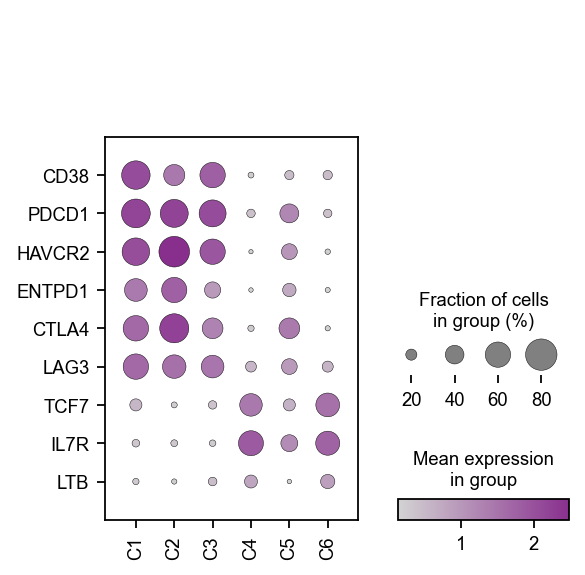

In [18]:
# create a dotplot for selected genes:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2,2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.dotplot(cd8_adata, ['CD38', 'PDCD1', 'HAVCR2', 'ENTPD1', 'CTLA4', 'LAG3', 'TCF7', 'IL7R', 'LTB'], groupby='cluster_num', dendrogram=False, swap_axes = True, cmap = cmap)
# sc.pl.dotplot(cd8_adata, ['CD38', 'PDCD1', 'HAVCR2', 'ENTPD1', 'CTLA4', 'LAG3', 'TCF7', 'IL7R', 'LTB'], groupby='cluster_num', dendrogram=False, swap_axes = True, cmap = cmap, save = f'for_or_yam_purple')

# Main Figure 5 - panels A-B:

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


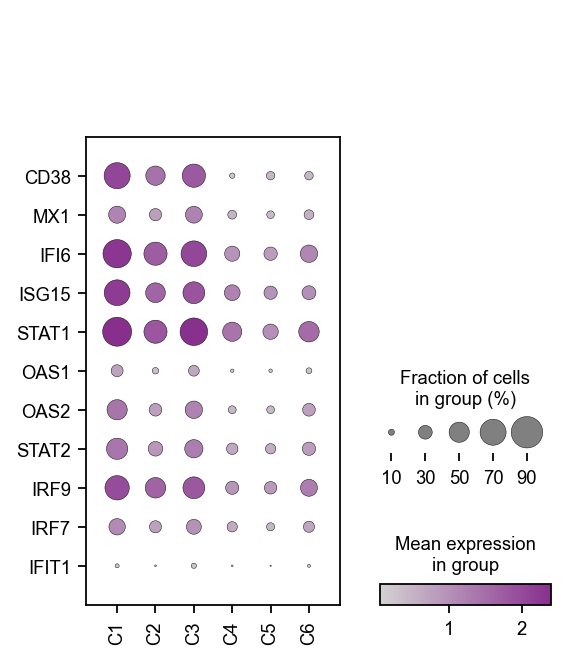

In [19]:
# create a dotplot for selected genes:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2,2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.dotplot(cd8_adata, ['CD38', 'MX1', 'IFI6', 'ISG15', 'STAT1', 'OAS1', 'OAS2', 'STAT2', 'IRF9', 'IRF7', 'IFIT1'], groupby='cluster_num', dendrogram=False, swap_axes = True, cmap = cmap)
# sc.pl.dotplot(cd8_adata, ['CD38', 'MX1', 'IFI6', 'ISG15', 'STAT1', 'OAS1', 'OAS2', 'STAT2', 'IRF9', 'IRF7', 'IFIT1'], groupby='cluster_num', dendrogram=False, swap_axes = True, cmap = cmap, save = f'1_cd8_genes_for_or_yam_purple')

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


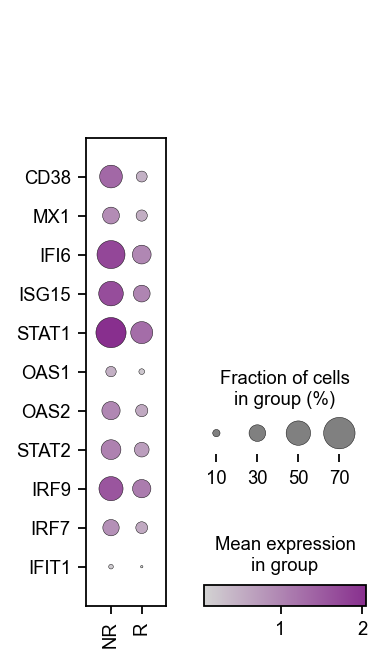

In [20]:
# create a dotplot for selected genes:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2,2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.dotplot(cd8_adata, ['CD38', 'MX1', 'IFI6', 'ISG15', 'STAT1', 'OAS1', 'OAS2', 'STAT2', 'IRF9', 'IRF7', 'IFIT1'], groupby='response', dendrogram=False, swap_axes = True, cmap = cmap)
# sc.pl.dotplot(cd8_adata, ['CD38', 'MX1', 'IFI6', 'ISG15', 'STAT1', 'OAS1', 'OAS2', 'STAT2', 'IRF9', 'IRF7', 'IFIT1'], groupby='response', dendrogram=False, swap_axes = True, cmap = cmap, save = f'1_cd8_genes_response_for_or_yam_purple')

# Main Figure 1 - panels F-G  &  Supp. Figure 1 - panels D-E

In [21]:
# create a dataframe from our anndata object for the next part of the analysis:
cd8_df = pd.DataFrame(cd8_adata.X)
cd8_df.index = cd8_adata.obs_names
cd8_df.columns = cd8_adata.var_names
for col in cd8_adata.obs.columns:
    cd8_df[col] = cd8_adata.obs[col]
cd8_df

,A1BG,A2M,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,gender,age,therapy,survival_days,status,biopsyNum,plate,MNum,rMito,cluster_num
C00349,3.288358,0.0,0.000000,3.291309,0.000000,0.000000,3.305971,0.0,0.000000,0.0,...,M,49,CTLA4+PD1,388,0,1,P03,MMD4,0.2959,C5
C01459,0.000000,0.0,2.587365,0.000000,0.000000,0.000000,2.014355,0.0,0.000000,0.0,...,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,2,P04,M55,0.0227,C6
C01471,0.000000,0.0,0.000000,0.000000,0.000000,2.786596,2.629939,0.0,0.000000,0.0,...,M,75,PD1,347,1,1,P03,M39,0.0073,C1
C01474,2.555816,0.0,1.855990,0.000000,2.397803,1.974529,2.140779,0.0,2.778208,0.0,...,M,75,PD1,347,1,1,P03,M39,0.0072,C1
C01475,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,M,75,PD1,347,1,1,P04,M39,0.1113,C6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16281,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.203201,0.0,...,F,65,PD1,130,0,1,P04,M76,0.046,C1
C16283,3.132577,0.0,3.250962,0.000000,3.000000,3.116032,0.000000,0.0,0.000000,0.0,...,F,65,PD1,130,0,1,P02,M76,0.0459,C1
C16285,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.106013,0.0,0.000000,0.0,...,F,65,PD1,130,0,1,P03,M76,0.0212,C1
C16287,0.000000,0.0,2.869871,0.000000,0.000000,2.049631,2.967169,0.0,0.000000,0.0,...,F,65,PD1,130,0,1,P04,M76,0.0488,C1


In [22]:
# create a CD38 status for every CD8 T cell:
cd8_df['CD38_status'] = cd8_df['CD38'].apply(lambda x: 'CD38+' if x > 2.5 else 'CD38-')

In [23]:
# create a dataframe showing the ratio of CD38_neg cells out of all the cells per sample:
ratios_df = cd8_df.groupby(['patient', 'response', 'prepost'])['CD38_status'].value_counts().unstack()
ratios_df = ratios_df.replace(np.nan, 0)
ratios_df['fraction'] = (ratios_df['CD38+'] / (ratios_df['CD38-'] + ratios_df['CD38+']))
ratios_df = ratios_df.reset_index().rename_axis('index')
# inserted 'Binary Response' for calculation of ROC/AUC:
ratios_df['Binary Response'] = ratios_df['response'].apply(lambda x: 1 if x == 'R' else 0)
ratios_df['b2m_samples'] = ratios_df['patient'].apply(lambda x: True if x.endswith('P3') or x.endswith('P3_2') or x.endswith('P15') or x.endswith('P25') else False)
ratios_df

CD38_status,patient,response,prepost,CD38+,CD38-,fraction,Binary Response,b2m_samples
index,,,,,,,,
0,Post_P1,R,Post,41,102,0.286713,1,False
1,Post_P1_2,NR,Post,63,130,0.326425,0,False
2,Post_P2,NR,Post,65,106,0.380117,0,False
3,Post_P3,NR,Post,16,136,0.105263,0,True
4,Post_P3_2,NR,Post,20,205,0.088889,0,True
5,Post_P4,R,Post,8,46,0.148148,1,False
6,Post_P5,NR,Post,32,111,0.223776,0,False
7,Post_P5_2,R,Post,10,233,0.041152,1,False
8,Post_P6,NR,Post,62,12,0.837838,0,False


In [24]:
# calculate p-value using two-sided t-test:
pvalue = ttest_ind(ratios_df['fraction'][ratios_df['Binary Response'] == 1], ratios_df['fraction'][ratios_df['Binary Response'] == 0])[1]
pvalue = f'{pvalue:.3f}' if pvalue * 10**3 > 1 else f'{pvalue:.2e}'
if 'e' in pvalue:
    pvalue = pvalue.split('e')
    pvalue[1] = '-' + pvalue[1][1:]
    pvalue[1] = str(int(pvalue[1]))
    pvalue = f'{pvalue[0]}*' + fr'$10^{{{pvalue[1]}}}$'

C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, '0.0'),
  Text(0, 0, '0.2'),
  Text(0, 0, '0.4'),
  Text(0, 0, '0.6'),
  Text(0, 0, '0.8'),
  Text(0, 0, '1.0')])

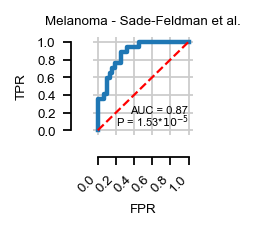

In [25]:
# create the ROC curve and calculate AUC score:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(12, 12), fontsize = 6, facecolor='white', format = 'tiff')
X = ratios_df[['fraction']]
y = ratios_df[['Binary Response']]
log_regression = LogisticRegression()
log_regression.fit(X,y)
y_pred_proba = log_regression.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y, y_pred_proba)
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)

plt.figure(figsize = (0.8,0.8))
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Melanoma - Sade-Feldman et al.', size = 6)
#plt.grid()
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.05)
yticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.yticks(yticks_loc)
xticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(yticks_loc)
#plot a diagonal line
plt.plot([0,1],[0,1], color = 'red', ls="--", lw = 1)
plt.annotate(f'AUC = {auc:.2f}', [0.35, 0.2], size = 5)
plt.annotate(f'P = {pvalue}', [0.2, 0.05], size = 5)
sns.despine(offset = 10, trim = True)
plt.xticks(rotation=45, ha = 'right',  position=(0,0))
# plt.savefig(r'%s' % os.path.join(r'cd38_project\auc_melanoma_for_or_yam_corrected.jpeg'), bbox_inches='tight', dpi=600)

In [26]:
# re-arrange df for Or-yam:
ratios_df.columns.name = ''
ratios_df = ratios_df.set_index('patient')
ratios_df = ratios_df.rename(columns = {'prepost' : 'Binary Treatment'})
ratios_df = ratios_df.rename_axis('sample')
ratios_df

,response,Binary Treatment,CD38+,CD38-,fraction,Binary Response,b2m_samples
sample,,,,,,,
Post_P1,R,Post,41,102,0.286713,1,False
Post_P1_2,NR,Post,63,130,0.326425,0,False
Post_P2,NR,Post,65,106,0.380117,0,False
Post_P3,NR,Post,16,136,0.105263,0,True
Post_P3_2,NR,Post,20,205,0.088889,0,True
Post_P4,R,Post,8,46,0.148148,1,False
Post_P5,NR,Post,32,111,0.223776,0,False
Post_P5_2,R,Post,10,233,0.041152,1,False
Post_P6,NR,Post,62,12,0.837838,0,False


In [27]:
# save the raw data for Or-yam - this was used for Main Figure 1 - panel F, as well as Supp. Figure 1 panels D-E,
# in a separate code by Or-yam:
# ratios_df.to_csv(r"cd38_project\melanoma_data.csv")

# Main Figure 3 - panel C:

## DEGs:

In [28]:
# consider only genes that are expressed in at least 10% of the cells in at least one of the groups ('CD38+' / 'CD38-'):
my_genes = []
dataframe = cd8_df
groups_list = ['CD38+', 'CD38-']
subset_groups_name = 'CD38_status'

for group in groups_list:
    group_size = dataframe[dataframe[subset_groups_name] == group].shape[0]
    tmp = dataframe[dataframe[subset_groups_name] == group].iloc[:, :-19]
    tmp.loc['num_of_expressing_cells'] = np.count_nonzero(tmp > 2.5, axis = 0)
    tmp = tmp.transpose()
    tmp = tmp[tmp['num_of_expressing_cells'] > 0.1*group_size]
    tmp = tmp.transpose()
    
    my_genes += list(tmp.columns)
my_genes = list(set(my_genes))
len(my_genes)

5326

In [29]:
#create our function to calculate p_values for all of the genes using Fisher's exact test:
def fisher_test_cluster_vs_rest(dataframe, cluster_num):
    genes_dict = {'Gene' :[], 'P-value': [], 'Expressing Cells Within Cluster' : [], 'Expressing Cells Other Clusters' : []} #added here the 'cluster_num_expressed' column for filtration of genes 
    for gene in gene_list:
        #values for Fisher's exact test:
        cluster_num_expressed = dataframe[(dataframe[subset_groups_name] == cluster_num) & (dataframe[gene] > 2.5)].shape[0]
        cluster_num_non_expressed = dataframe[(dataframe[subset_groups_name] == cluster_num) & (dataframe[gene] <= 2.5)].shape[0]
        rest_expressed = dataframe[(dataframe[subset_groups_name] != cluster_num) & (dataframe[gene] > 2.5)].shape[0]
        rest_non_expressed = dataframe[(dataframe[subset_groups_name] != cluster_num) & (dataframe[gene] <= 2.5)].shape[0]
        oddsratio, pvalue = fisher_exact([[cluster_num_expressed, rest_expressed], [cluster_num_non_expressed, rest_non_expressed]])
        genes_dict['Gene'].append(gene)
        genes_dict['P-value'].append(pvalue)
        genes_dict['Expressing Cells Within Cluster'].append(cluster_num_expressed) #additional value for filtration of genes
        genes_dict['Expressing Cells Other Clusters'].append(rest_expressed)
    return genes_dict

#create our function to calculate log2 Fold Changes for all of the genes:
def fold_change_genes(dataframe, cluster_num):
    genes_dict = {'Gene' :[], 'Mean Expression Cluster' : [], 'Mean Expression Rest' : [], 'Fold Change (log2)': [], 'Direction' : []}
    for gene in gene_list:
        #values for Fold Change:
        cluster_mean = dataframe[gene][dataframe[subset_groups_name] == cluster_num].mean()
        rest_mean = dataframe[gene][dataframe[subset_groups_name] != cluster_num].mean()
        
        fold_change = np.log2(cluster_mean / rest_mean)
        direction = 'Cluster ' + str(cluster_num) if (cluster_mean > rest_mean) else 'Rest'

        genes_dict['Gene'].append(gene)
        genes_dict['Fold Change (log2)'].append(fold_change)
        genes_dict['Direction'].append(direction)
        genes_dict['Mean Expression Cluster'].append(cluster_mean)
        genes_dict['Mean Expression Rest'].append(rest_mean)
    return genes_dict

# Apply the functions to calculate DEGs for each group ('CD38+' / 'CD38-'), using the selected list of genes:
gene_list = my_genes
for cluster_num in groups_list:
    p_values_cluster_vs_rest_df = pd.DataFrame(fisher_test_cluster_vs_rest(dataframe, cluster_num))
    p_values_cluster_vs_rest_df['Expressing Cells Within Cluster (%)'] = 100 * (p_values_cluster_vs_rest_df['Expressing Cells Within Cluster'] / np.count_nonzero(dataframe[subset_groups_name] == cluster_num))
    p_values_cluster_vs_rest_df['Expressing Cells Other Clusters (%)'] = 100 * (p_values_cluster_vs_rest_df['Expressing Cells Other Clusters'] / np.count_nonzero(dataframe[subset_groups_name] != cluster_num))
    p_values_cluster_vs_rest_df['Boolean FDR'] = fdrcorrection(p_values_cluster_vs_rest_df['P-value'])[0]
    p_values_cluster_vs_rest_df['FDR P_value'] = fdrcorrection(p_values_cluster_vs_rest_df['P-value'])[1]
    fold_changes = pd.DataFrame(fold_change_genes(dataframe, cluster_num))
    my_df = p_values_cluster_vs_rest_df.merge(fold_changes, on = 'Gene')
    my_df = my_df[my_df['Direction'] == ('Cluster ' + str(cluster_num))].sort_values(by = 'P-value').reset_index(drop = True)
    my_df.to_excel(os.path.join('cd38_project',f"differentially_expressed_genes_{cluster_num}_16k_melanoma.xlsx"))

# Supp. Figure 5 - panels A, C:

## Now find DEGs using all of the genes for GSEA:

In [30]:
my_genes = []
dataframe = cd8_df
groups_list = ['CD38+', 'CD38-']
subset_groups_name = 'CD38_status'

# remove genes with zero mean in at least one of the groups as it makes the rank infinite...
genes_to_remove = []
for group in groups_list:
    tmp = dataframe[dataframe[subset_groups_name] == group].mean()  
    genes_to_remove += list(tmp[tmp == 0].index)
genes_to_remove = list(set(genes_to_remove))

my_genes = pd.Series(dataframe.iloc[:, :-19].columns)
my_genes = my_genes[~my_genes.isin(genes_to_remove)]
my_genes = list(my_genes)
len(my_genes)

C:\Users\KerenYlab\AppData\Local\Temp\ipykernel_11784\921263958.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tmp = dataframe[dataframe[subset_groups_name] == group].mean()
C:\Users\KerenYlab\AppData\Local\Temp\ipykernel_11784\921263958.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tmp = dataframe[dataframe[subset_groups_name] == group].mean()


12305

In [31]:
#create our function to calculate p_values for all of the genes using Fisher's exact test:
def fisher_test_cluster_vs_rest(dataframe, cluster_num):
    genes_dict = {'Gene' :[], 'P-value': [], 'Expressing Cells Within Cluster' : [], 'Expressing Cells Other Clusters' : []} #added here the 'cluster_num_expressed' column for filtration of genes 
    for gene in gene_list:
        #values for Fisher's exact test:
        cluster_num_expressed = dataframe[(dataframe[subset_groups_name] == cluster_num) & (dataframe[gene] > 2.5)].shape[0]
        cluster_num_non_expressed = dataframe[(dataframe[subset_groups_name] == cluster_num) & (dataframe[gene] <= 2.5)].shape[0]
        rest_expressed = dataframe[(dataframe[subset_groups_name] != cluster_num) & (dataframe[gene] > 2.5)].shape[0]
        rest_non_expressed = dataframe[(dataframe[subset_groups_name] != cluster_num) & (dataframe[gene] <= 2.5)].shape[0]
        oddsratio, pvalue = fisher_exact([[cluster_num_expressed, rest_expressed], [cluster_num_non_expressed, rest_non_expressed]])
        genes_dict['Gene'].append(gene)
        genes_dict['P-value'].append(pvalue)
        genes_dict['Expressing Cells Within Cluster'].append(cluster_num_expressed) #additional value for filtration of genes
        genes_dict['Expressing Cells Other Clusters'].append(rest_expressed)
    return genes_dict

#create our function to calculate log2 Fold Changes for all of the genes:
def fold_change_genes(dataframe, cluster_num):
    genes_dict = {'Gene' :[], 'Mean Expression Cluster' : [], 'Mean Expression Rest' : [], 'Fold Change (log2)': [], 'Direction' : []}
    for gene in gene_list:
        #values for Fold Change:
        cluster_mean = dataframe[gene][dataframe[subset_groups_name] == cluster_num].mean()
        rest_mean = dataframe[gene][dataframe[subset_groups_name] != cluster_num].mean()
        
        fold_change = np.log2(cluster_mean / rest_mean)
        direction = 'Cluster ' + str(cluster_num) if (cluster_mean > rest_mean) else 'Rest'

        genes_dict['Gene'].append(gene)
        genes_dict['Fold Change (log2)'].append(fold_change)
        genes_dict['Direction'].append(direction)
        genes_dict['Mean Expression Cluster'].append(cluster_mean)
        genes_dict['Mean Expression Rest'].append(rest_mean)
    return genes_dict

# Apply the functions to calculate DEGs for each group ('CD38+' / 'CD38-'), using the selected list of genes:
gene_list = my_genes
for cluster_num in groups_list:
    p_values_cluster_vs_rest_df = pd.DataFrame(fisher_test_cluster_vs_rest(dataframe, cluster_num))
    p_values_cluster_vs_rest_df['Expressing Cells Within Cluster (%)'] = 100 * (p_values_cluster_vs_rest_df['Expressing Cells Within Cluster'] / np.count_nonzero(dataframe[subset_groups_name] == cluster_num))
    p_values_cluster_vs_rest_df['Expressing Cells Other Clusters (%)'] = 100 * (p_values_cluster_vs_rest_df['Expressing Cells Other Clusters'] / np.count_nonzero(dataframe[subset_groups_name] != cluster_num))
    p_values_cluster_vs_rest_df['Boolean FDR'] = fdrcorrection(p_values_cluster_vs_rest_df['P-value'])[0]
    p_values_cluster_vs_rest_df['FDR P_value'] = fdrcorrection(p_values_cluster_vs_rest_df['P-value'])[1]
    fold_changes = pd.DataFrame(fold_change_genes(dataframe, cluster_num))
    my_df = p_values_cluster_vs_rest_df.merge(fold_changes, on = 'Gene')
    my_df = my_df[my_df['Direction'] == ('Cluster ' + str(cluster_num))].sort_values(by = 'P-value').reset_index(drop = True)
    my_df.to_excel(os.path.join('cd38_project',f"differentially_expressed_genes_{cluster_num}_16k_melanoma_all_protein_coding_genes.xlsx"))

In [32]:
# Now rank the genes from both groups:
# pay attention to the error of dividing by zero - it's because 'CD38' which differentiates both groups of course...
cd38pos_df = pd.read_excel(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\differentially_expressed_genes_CD38pos_16k_melanoma_all_protein_coding_genes.xlsx", index_col = 0)
cd38pos_df = cd38pos_df[['Gene', 'P-value', 'FDR P_value', 'Fold Change (log2)']]
cd38pos_df['log_pvalue'] = -np.log10(cd38pos_df['P-value'])
cd38pos_df = cd38pos_df.sort_values(by = 'Fold Change (log2)', ascending = False).reset_index(drop = True)

cd38neg_df = pd.read_excel(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project\differentially_expressed_genes_CD38neg_16k_melanoma_all_protein_coding_genes.xlsx", index_col = 0)
cd38neg_df = cd38neg_df[['Gene', 'P-value', 'FDR P_value', 'Fold Change (log2)']]
cd38neg_df['log_pvalue'] = -np.log10(cd38neg_df['P-value'])
cd38neg_df['Fold Change (log2)'] = -cd38neg_df['Fold Change (log2)']
cd38neg_df = cd38neg_df.sort_values(by = 'Fold Change (log2)', ascending = False).reset_index(drop = True)

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
# This ranked list of genes was used in a separate code to create panels A, C in Supp. Figure 5 by Or-yam:
gene_rank = pd.concat([cd38pos_df, cd38neg_df])
gene_rank = gene_rank[['Gene', 'P-value', 'Fold Change (log2)', 'log_pvalue', 'FDR P_value']].reset_index(drop = True)
gene_rank['rank'] = gene_rank['log_pvalue'] * gene_rank['Fold Change (log2)']
gene_rank = gene_rank.sort_values(by = 'rank', ascending = False).reset_index(drop = True)
# gene_rank.to_csv(r"cd38_project\rank_data_GSEA_for_or_yam.csv")
gene_rank

,Gene,P-value,Fold Change (log2),log_pvalue,FDR P_value,rank
0,CD38,0.000000e+00,4.565456,inf,0.000000e+00,inf
1,HAVCR2,6.279686e-122,1.096765,121.202062,3.863577e-118,132.930212
2,EPSTI1,1.964790e-83,1.226552,82.706684,2.686304e-80,101.444018
3,TK1,4.638680e-49,1.918992,48.333606,6.272413e-47,92.751824
4,KIAA0101,1.752706e-55,1.675639,54.756291,3.535582e-53,91.751790
...,...,...,...,...,...,...
12300,SORL1,4.123454e-34,-1.304951,33.384739,1.886212e-32,-43.565438
12301,TCF7,2.219281e-43,-1.079178,42.653788,2.100635e-41,-46.031043
12302,CCR7,6.333022e-38,-1.690665,37.198389,4.079991e-36,-62.890006
12303,S1PR1,7.143295e-42,-1.673688,41.146101,6.020427e-40,-68.865753


# Supp. Figure 1 - panels A, C:

In [34]:
# Add the single-cell metadata to the anndata object:
for col in metadata.columns:
    adata.obs[col] = metadata[col]
adata

AnnData object with n_obs × n_vars = 16291 × 12364
    obs: 'response', 'patient', 'cluster_all', 'isCD8', 'cluster_cd8', 'isDNDP', 'prepost', 'pNum', 'gender', 'age', 'therapy', 'survival_days', 'status', 'biopsyNum', 'plate', 'MNum', 'rMito'
    uns: 'log1p'

In [35]:
# add tSNE coordinates for all the single cells:
adata.obsm['X_tsne'] = tsne_all[['numeric', 'numeric.1']].values

In [36]:
# map each cluster to its cluster name according to the authors:
cluster2annotation = {
     'G01': 'G01: B Cells',
     'G02': 'G02: Plasma Cells',
     'G03': 'G03: Monocytes / macrophages',
     'G04': 'G04: Dentritic Cells',
     'G05': 'G05: Lymphocytes',
     'G06': 'G06: Exhausted CD8+ T Cells',
     'G07': 'G07: Tregs',
     'G08': 'G08: Cytotoxicity (Lymphocytes)',
     'G09': 'G09: Exhausted/HS CD8+ T Cells',
     'G10': 'G10: Memory T Cells',
     'G11': 'G11: Lymphocytes Exhausted / Cell Cycle',
}

# add a new `.obs` column by mapping clusters to annotation using pandas `map` function:
adata.obs['cell_type'] = adata.obs['cluster_all'].map(cluster2annotation).astype('category')

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


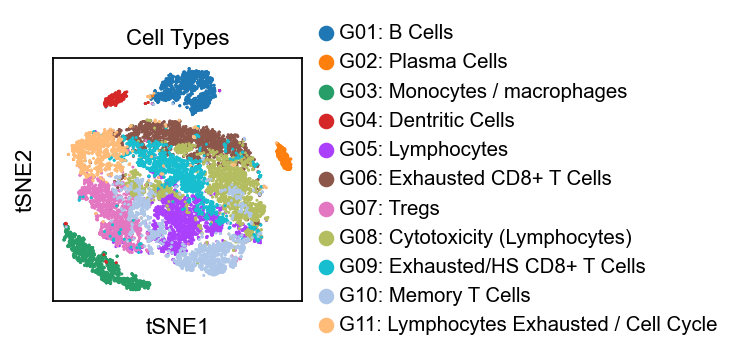

In [37]:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2, 2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.tsne(adata, color = ['cell_type'], title = ['Cell Types'])
# sc.pl.tsne(adata, color = ['cell_type'], title = ['Cell Types'], save = '_Cell_Types_for_or_yam')

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


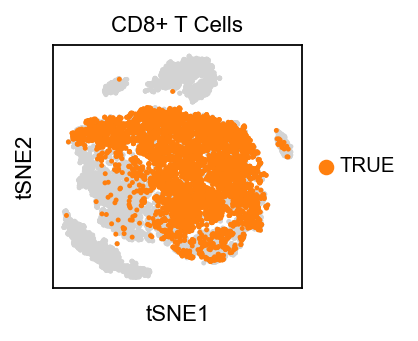

In [38]:
sc.pl.tsne(adata, color = ['isCD8'], groups = ['TRUE'], title = ['CD8+ T Cells'], size = 20, hspace = 0.4, wspace = 0.4, na_in_legend = False)

In [39]:
# Change color according to Or-yam:
adata.uns['isCD8_colors'][1] = '#882f8e'

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


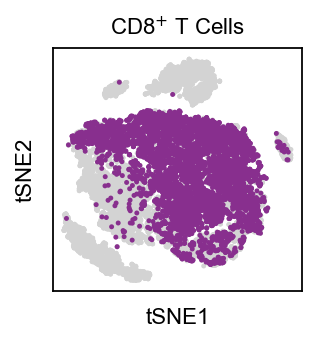

In [40]:
sc.pl.tsne(adata, color = ['isCD8'], groups = ['TRUE'], title = ['CD8$^{+}$ T Cells'], size = 20, hspace = 0.4, wspace = 0.4, na_in_legend = False, legend_loc = None)
# sc.pl.tsne(adata, color = ['isCD8'], groups = ['TRUE'], title = ['CD8$^{+}$ T Cells'], size = 20, hspace = 0.4, wspace = 0.4, na_in_legend = False, legend_loc = None, save = f'_all_cells_isCD8_for_or_yam_purple')

# Supp Figure 7 - panels A-B  &  Supp. Figure 1 - panel B:

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


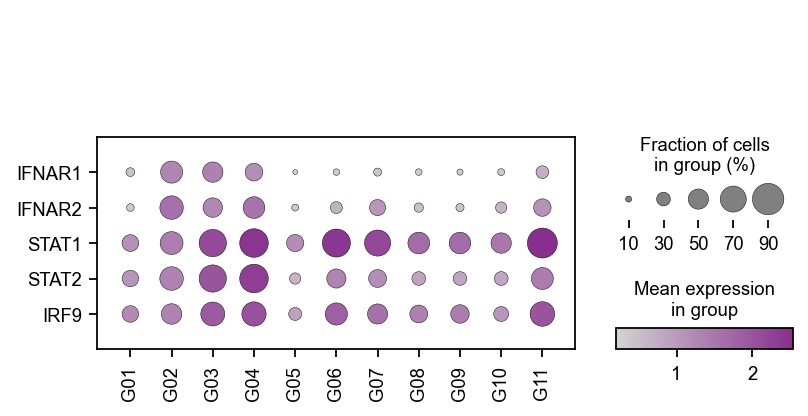

In [41]:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2,2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.dotplot(adata, ['IFNAR1', 'IFNAR2', 'STAT1', 'STAT2', 'IRF9'], groupby='cluster_all', dendrogram=False, swap_axes = True, cmap = cmap, save = f'2_all_cells_genes_for_or_yam_purple')

In [42]:
# pay attention that response data from the portal contains these DN_DP cells:
adata.obs.groupby('response').size()

response
DN_DP_plates      991
NR              10190
R                5110
dtype: int64

In [43]:
# I therefore removed these 'DN_DP' cells which have no response and no attribution to patient/sample:
adata = adata[adata.obs['response'].isin(['R', 'NR'])]

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


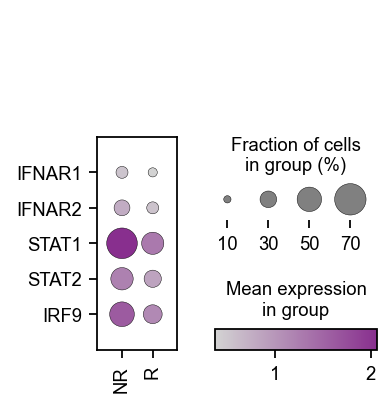

In [44]:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2,2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.dotplot(adata, ['IFNAR1', 'IFNAR2', 'STAT1', 'STAT2', 'IRF9'], groupby='response', dendrogram=False, swap_axes = True, cmap = cmap, save = f'2_all_cells_genes_response_for_or_yam_purple')

In [45]:
# Change color according to Or-yam:
adata.uns['response_colors'] = ['#882f8e', '#d3d3d3']

C:\Users\KerenYlab\AppData\Local\Temp\ipykernel_11784\1893926355.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['response_colors'] = ['#882f8e', '#d3d3d3']


C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


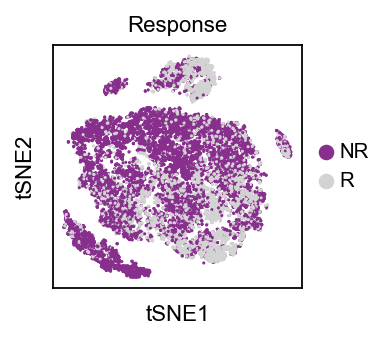

In [46]:
sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(2, 2), fontsize = 10, facecolor='white', format = 'jpeg')
sc.pl.tsne(adata, color = ['response'], title = ['Response'], na_in_legend = False, save = '_response_all_clusters_or_yam_palette')

# Main Figure 1 - panel H  &  Supp. Figure 1 - panels H-Q:

In [47]:
clusters_cd38_df = sc.get.obs_df(adata, ['cluster_all', 'CD38', 'prepost', 'response', 'patient'])
clusters_cd38_df

,cluster_all,CD38,prepost,response,patient
C00001,G01,0.000000,Pre,R,Pre_P1
C00002,G01,0.000000,Post,R,Post_P1
C00003,G01,0.000000,Post,R,Post_P1
C00004,G01,0.000000,Post,R,Post_P1
C00005,G01,0.000000,Post,NR,Post_P1_2
...,...,...,...,...,...
C16287,G11,1.967169,Pre,R,Pre_P33
C16288,G11,0.000000,Pre,R,Pre_P33
C16289,G11,0.000000,Pre,R,Pre_P35
C16290,G11,3.190615,Pre,R,Pre_P35


C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vecto

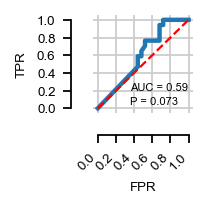

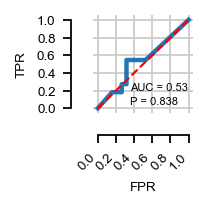

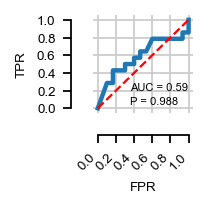

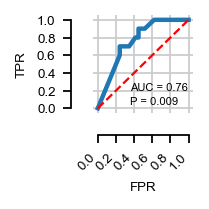

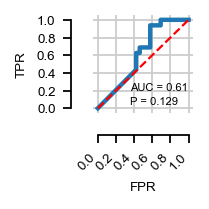

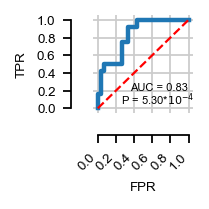

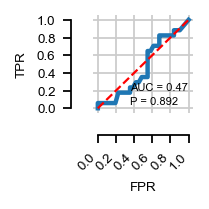

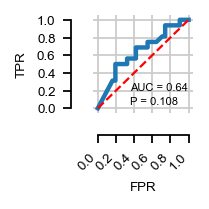

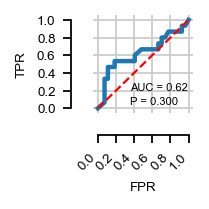

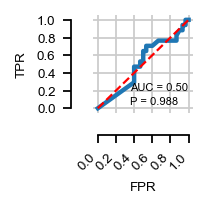

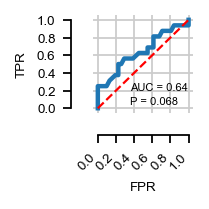

In [48]:
for cell_type in list(adata.obs['cluster_all'].unique()):
    my_tmp_df = clusters_cd38_df[clusters_cd38_df['cluster_all'] == cell_type]
    samples = list(my_tmp_df['patient'].unique())

    ratios = []
    goods = []
    bads = []
    for sample in samples:
        good = my_tmp_df[['patient', 'CD38']][(my_tmp_df['patient'] == sample) & (my_tmp_df['CD38'] <= 2.5)].shape[0]
        bad = my_tmp_df[['patient', 'CD38']][(my_tmp_df['patient'] == sample) & (my_tmp_df['CD38'] > 2.5)].shape[0]
        ratio = bad / (bad + good)
        ratios.append(ratio)
        goods.append(good)
        bads.append(bad)

    ratios_df = pd.DataFrame({'patient' : samples, 'CD38-' : goods, 'CD38+' : bads, 'fraction' : ratios})
    ratios_df = ratios_df.set_index('patient')
    ratios_df['response'] = clusters_cd38_df[['patient', 'response']].drop_duplicates().set_index('patient')['response']
    ratios_df['Binary Response'] = ratios_df['response'].apply(lambda x: 1 if x == 'R' else 0)

    sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(12, 12), fontsize = 6, facecolor='white', format = 'tiff')
    X = ratios_df[['fraction']]
    y = ratios_df[['Binary Response']]
    log_regression = LogisticRegression()
    log_regression.fit(X,y)
    y_pred_proba = log_regression.predict_proba(X)[::,1]
    auc = metrics.roc_auc_score(y, y_pred_proba)
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)

    # calculate p-value using two-sided t-test:
    pvalue = ttest_ind(ratios_df['fraction'][ratios_df['Binary Response'] == 1], ratios_df['fraction'][ratios_df['Binary Response'] == 0])[1]

    pvalue = f'{pvalue:.3f}' if pvalue * 10**3 > 1 else f'{pvalue:.2e}'
    if 'e' in pvalue:
        pvalue = pvalue.split('e')
        pvalue[1] = '-' + pvalue[1][1:]
        pvalue[1] = str(int(pvalue[1]))
        pvalue = f'{pvalue[0]}*' + fr'$10^{{{pvalue[1]}}}$'

    if cell_type == 'G06':
        plt.figure(figsize = (0.8,0.8))
        lw = 2
        plt.plot(fpr, tpr, lw=lw)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.ylim(-0.05,1.05)
        plt.xlim(-0.05,1.05)
        yticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
        plt.yticks(yticks_loc)
        xticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
        plt.xticks(yticks_loc)
        #plot a diagonal line
        plt.plot([0,1],[0,1], color = 'red', ls="--", lw = 1)
        plt.annotate(f'AUC = {auc:.2f}', [0.35, 0.2], size = 5)
        plt.annotate(f'P = {pvalue}', [0.25, 0.05], size = 5)
        sns.despine(offset = 10, trim = True)
        plt.xticks(rotation=45, ha = 'right',  position=(0,0))
        plt.savefig(r'%s' % os.path.join(r'cd38_project', f'ROC_curve_Cell_2018_cluster_{cell_type}.jpeg'), bbox_inches='tight', dpi=600)
    else:
        plt.figure(figsize = (0.8,0.8))
        lw = 2
        plt.plot(fpr, tpr, lw=lw)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.ylim(-0.05,1.05)
        plt.xlim(-0.05,1.05)
        yticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
        plt.yticks(yticks_loc)
        xticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
        plt.xticks(yticks_loc)
        #plot a diagonal line
        plt.plot([0,1],[0,1], color = 'red', ls="--", lw = 1)
        plt.annotate(f'AUC = {auc:.2f}', [0.35, 0.2], size = 5)
        plt.annotate(f'P = {pvalue}', [0.35, 0.05], size = 5)
        sns.despine(offset = 10, trim = True)
        plt.xticks(rotation=45, ha = 'right',  position=(0,0))
        plt.savefig(r'%s' % os.path.join(r'cd38_project', f'ROC_curve_Cell_2018_cluster_{cell_type}.jpeg'), bbox_inches='tight', dpi=600)
